# Creating our base model using the generated dataset

## Step1: Merging the labels

Merging all the CSV files that include the labels, and the time frame of each sample.

In [4]:
import pandas as pd
import os

# Input label CSV paths and their corresponding class labels
csv_paths = [
    'Data/Images/AMP-mci/npy/labels.csv',
    'Data/Images/COC-mci/npy/labels.csv',
    'Data/Images/MAPB-mci/npy/labels.csv',
    'Data/Images/MDMA-mci/npy/labels.csv'
]
labels = ['AMP', 'COC', 'MAPB', 'MDMA']

# Output CSV path
output_path = 'Data/Images'
all_records = []

# Process each dataset
for csv_path, label in zip(csv_paths, labels):
    df = pd.read_csv(csv_path)

    # Ensure the label column is correct
    df['label'] = label

    # Keep only the PNG filename, not full path
    df['filepath'] = df['filename'].apply(lambda x: x.replace('.npy', '.png'))

    # Keep only relevant columns
    all_records.append(df[['filepath', 'label', 'frame']])

# Combine all into one master DataFrame
full_df = pd.concat(all_records, ignore_index=True)

# Save the combined labels CSV
master_csv_path = os.path.join(output_path, 'master_labels.csv')
full_df.to_csv(master_csv_path, index=False)

# Preview
print(f"Saved master_labels.csv with {len(full_df)} samples to: {master_csv_path}")
print(full_df.head())


Saved master_labels.csv with 750 samples to: Data/Images\master_labels.csv
            filepath label  frame
0  AMP_frame_595.png   AMP    595
1  AMP_frame_587.png   AMP    587
2  AMP_frame_543.png   AMP    543
3  AMP_frame_645.png   AMP    645
4  AMP_frame_487.png   AMP    487


## Step 2: creating our dataloader 

In [ ]:
#Always Run this when using IPYNB file!
import torch

print("CUDA Available:", torch.cuda.is_available())
print("CUDA Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")
print("Current Device Index:", torch.cuda.current_device())


CUDA Available: True
CUDA Device Name: NVIDIA GeForce RTX 4070 Ti
Current Device Index: 0


In [3]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision import transforms
from sklearn.model_selection import train_test_split

# ✅ Define the dataset class
class SubstanceDataset(Dataset):
    def __init__(self, csv_path, image_folder, transform=None):
        self.df = pd.read_csv(csv_path)
        self.image_folder = image_folder
        self.transform = transform
        self.label_map = {label: idx for idx, label in enumerate(sorted(self.df['label'].unique()))}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = f"{self.image_folder}/{row['filepath']}"
        image = read_image(img_path).float() / 255.0  # Shape: (1, H, W)
        if self.transform:
            image = self.transform(image)
        label = self.label_map[row['label']]
        return image, label

# ✅ Load and split the master CSV
df = pd.read_csv('Data/Images/master_labels.csv')
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df.to_csv('Data/Images/train.csv', index=False)
val_df.to_csv('Data/Images/val.csv', index=False)

# ✅ Image transformations
transform = transforms.Compose([
    transforms.Resize((64, 64))  # Resize to CNN input shape
])

# ✅ Loaders pointing to unified image folder
image_folder = 'Data/Images/All'

train_dataset = SubstanceDataset('Data/Images/train.csv', image_folder, transform=transform)
val_dataset = SubstanceDataset('Data/Images/val.csv', image_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


## Step 3: CNN model Draft

the name says it all 

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

# Device: use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define the CNN (from Step 3)
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.conv1 = nn.Conv2d(4, 16, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1   = nn.Linear(32 * 16 * 16, 128)  # Input shape: 64x64
        self.fc2   = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # (B, 16, 32, 32)
        x = self.pool(torch.relu(self.conv2(x)))  # (B, 32, 16, 16)
        x = x.view(x.size(0), -1)                 # Flatten
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Instantiate and move model to GPU
model = SimpleCNN(num_classes=4).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Using device: cuda


## Step 4: model training 

In [10]:
# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_loss = running_loss / total
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")

    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    print(f"           → Val Acc: {val_acc:.4f}")


Epoch [1/10] - Train Loss: 1.0413 | Train Acc: 0.4883
           → Val Acc: 0.4667
Epoch [2/10] - Train Loss: 0.6209 | Train Acc: 0.7217
           → Val Acc: 0.8000
Epoch [3/10] - Train Loss: 0.3173 | Train Acc: 0.8450
           → Val Acc: 0.8733
Epoch [4/10] - Train Loss: 0.1916 | Train Acc: 0.9333
           → Val Acc: 0.9667
Epoch [5/10] - Train Loss: 0.1214 | Train Acc: 0.9583
           → Val Acc: 0.9667
Epoch [6/10] - Train Loss: 0.0968 | Train Acc: 0.9583
           → Val Acc: 0.9667
Epoch [7/10] - Train Loss: 0.1028 | Train Acc: 0.9583
           → Val Acc: 0.9733
Epoch [8/10] - Train Loss: 0.0894 | Train Acc: 0.9617
           → Val Acc: 0.9667
Epoch [9/10] - Train Loss: 0.0965 | Train Acc: 0.9583
           → Val Acc: 0.9733
Epoch [10/10] - Train Loss: 0.0836 | Train Acc: 0.9667
           → Val Acc: 0.9667


## Step 5: Saving the model

In [11]:
torch.save(model.state_dict(), "substance_classifier.pth")

## Step 6: Testing 

The aim is to randomly select 5 images from a test dataset and see how accurate the model is 

In [27]:
# going to do some data augmentation to test the model output 

from PIL import Image, ImageEnhance
import os
import numpy as np
import torchvision.transforms.functional as F
import torchvision.transforms as T
import torch

# Your directories
input_dir = "Data/Images/Test/test_img"
output_dir = "Data/Images/Test/testv2"
os.makedirs(output_dir, exist_ok=True)

# Parameters
contrast_factor = 1.5     # Boost contrast
shear_degrees = 5         # Soft shear
noise_std = 0.02          # Add low noise

# Shear transformation
shear_transform = T.RandomAffine(degrees=0, shear=shear_degrees)

for fname in os.listdir(input_dir):
    if fname.endswith(".png"):
        img_path = os.path.join(input_dir, fname)
        img = Image.open(img_path).convert("RGBA")

        # 1. Contrast
        img = ImageEnhance.Contrast(img).enhance(contrast_factor)

        # 2. Shear
        img = shear_transform(img)

        # 3. Noise
        tensor_img = F.to_tensor(img)
        noise = torch.randn_like(tensor_img) * noise_std
        noisy_tensor = torch.clamp(tensor_img + noise, 0.0, 1.0)

        # Save with original filename
        final_img = F.to_pil_image(noisy_tensor)
        final_img.save(os.path.join(output_dir, fname))



C:\Users\Amir\AppData\Local\Temp\ipykernel_25880\2698989968.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("substance_classifier.pth",

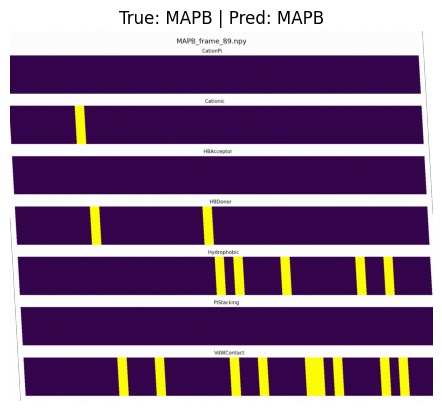

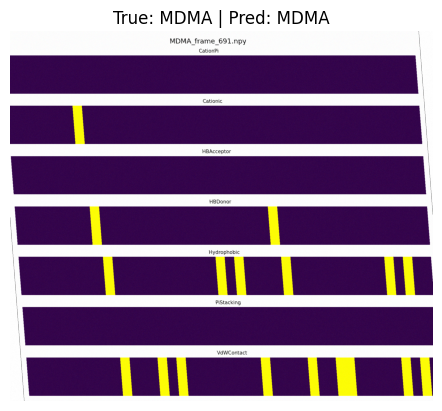

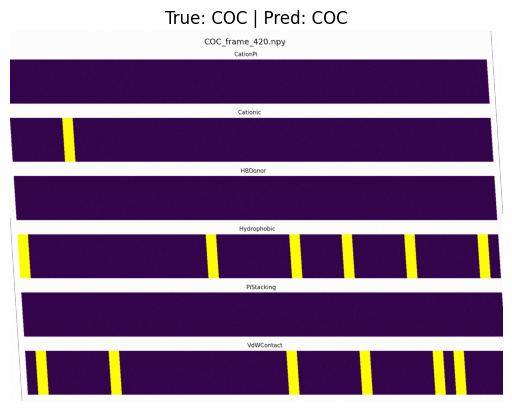

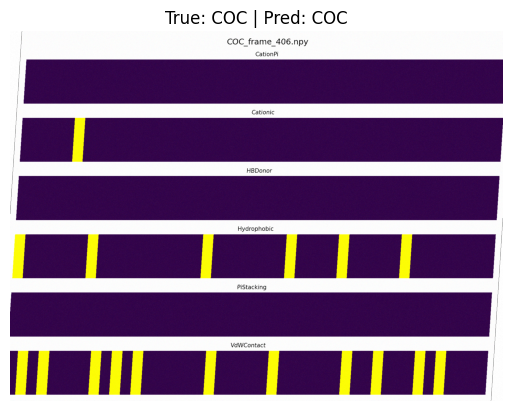

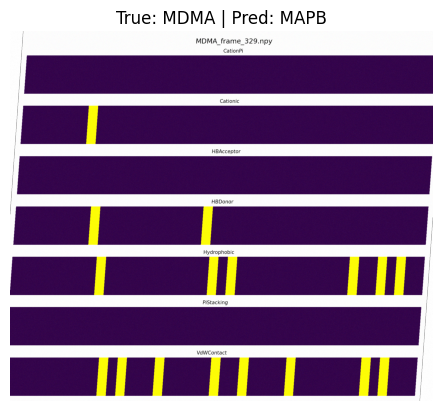

In [29]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, Resize, ToTensor
from PIL import Image

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Label map (you can extract from your dataset)
label_map = {0: 'AMP', 1: 'COC', 2: 'MAPB', 3: 'MDMA'}
label_to_idx = {v: k for k, v in label_map.items()}

# Define transforms
transform = Compose([
    Resize((64, 64)),
    ToTensor()  # Keeps 4 channels if input is RGBA
])

# Load model
class SimpleCNN(torch.nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(4, 16, kernel_size=3, padding=1)
        self.pool  = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1   = torch.nn.Linear(32 * 16 * 16, 128)
        self.fc2   = torch.nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Load the trained weights
model = SimpleCNN(num_classes=4).to(device)
model.load_state_dict(torch.load("substance_classifier.pth", map_location=device))
model.eval()

# Load data
df = pd.read_csv("Data/Images/Test/Test_labels.csv")
image_folder = "Data/Images/Test/testv2"

# Select 5 random samples
sampled = df.sample(5)

# Predict and show results
for _, row in sampled.iterrows():
    filepath = f"{image_folder}/{row['filepath']}"
    image = Image.open(filepath).convert("RGBA")  # Ensure 4-channel
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        pred_idx = torch.argmax(output, dim=1).item()
        pred_label = label_map[pred_idx]

    # Show image and prediction
    plt.imshow(image)
    plt.title(f"True: {row['label']} | Pred: {pred_label}")
    plt.axis('off')
    plt.show()
